In [17]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [18]:
# Ensemble Learning
# - aggregate the predictions of a groups of predictors -> often leads to better prediction than only with one best predictor
# - Ensemble learning algorihm - called Ensemble method

# E.g. can train a group of DT classifiers, each on a different random subset of the training set
# - to make a prediction - predicts the class that gets the most votes 
# -> such ensemble of DTs: Random Forest - very simple but one of the most powerful ML algorithms

In [19]:
# Voting Classifiers
# create multiple classifiers and aggregate the predictions of each classifier and predict the class that gets the most votes
# -> called hard voting classifier

# often achieves a higher accuracy than the best classifier in the ensemble
# even if each classifier is a weak learner (slightly better than random guessing) - the ensemble cans till be a strong learner (given enough classifiers)
# works due to the law of large numbers

In [20]:
# Creating and trainng a voting classifier in Scikit-Learn:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [21]:
# Accuracy of each classifier on the test set:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


In [22]:
# Voting classifier slighlty outperforms all individual classifiers

In [23]:
# Soft voting:
# - if all classifiers can estimate class probabilities (i.e. predict_prob() method)
# - Scikit-Learn allows you to predict the class with the highest probability, averaged over all the individual classifiers (soft voting)
# often better than hard voting, since it gives more weight to highly confident votes - replace voting="hard" to voting="soft":

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [24]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


In [25]:
# The prediction accuracy jumpted to 92%
# Make sure all classifiers can estimate class probabilities -> not the case for SVC by default
# -> set probability hyperparameter to true

In [26]:
# Bagging and Pasting
# Different approach to diversify classifiers:
# - use same training algorithm for every predictor, but train them on different random subsets of the training set
# - if you sample with replacement (sample can be selected more than once for one predictor) - called bagging (short for bootstrap aggregating)
# - if no replacement (sample can be selected only once for one predictor) - called pasting

# Once all predictors are trained - an ensemble can make a prediction for a new instance by simply aggregating all predictions
# - aggregation function is typically the statistical mode, i.e. the most frequent predicition, just like a hard voting classifier, for classification
#   or the average for regression

# Each individual predictor - higher bias than if trained on the whole training set but aggregation reduces both BIAS and VARIANCE
# Generally, net result: ensemble has similar bias but lower variance than a single predictor trained on the original training set

# One can train multiple predictors in parallel, via different CPU cores
# Similarly - predictions can also be made in parallel - they scale well (which makes them popular)

In [27]:
# Example using Scikit-Learn
# Let's train 500 DT classifiers, each trained on 100 training instnace randomly sampled from the training set - bagging
# (to do pasting - set bootstrap=False)
# n_jobs param tells how many CPU cores to use for training and predictions - -1 means to use all available cores
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [28]:
# BaggingClassifier automatically performed soft voting insted of hard if the base classifier can estimate probabilities - true for DTs
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.912


In [29]:
# Compare to a single DT:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [30]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

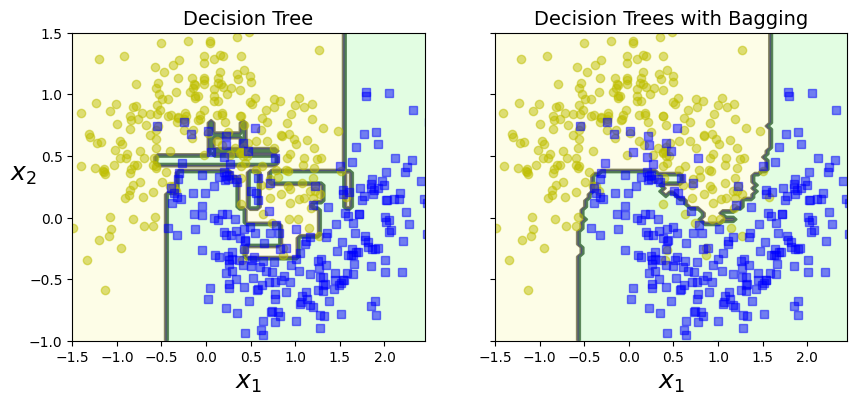

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

In [32]:
# Example of decision boundaries - single DT (left) vs Ensemble of DTs using bagging on moons dataset
# - ensemble's predictions will probably generalize better 
# - ensemble has comparable bias but smaller variance 
# (it roughly makes the same number of errors on the training set, but the decision boundary is less irregular)

In [33]:
# Bootstrapping introductes a bit more diversity in the subsets that each predictor is trained on
# thus, bagging ens up with a slighlty higher bias than pasting
# However, this means that predictors end up being less correlated so the ensemble's variance is reduced

# In general, bagging often results in better models - therefore it is usually perferred
# But if you have spare time and CPU power - do cross-validation and evaluate both bagging and pasting to see what works best

In [34]:
# Out-of-Bag Evaluation
# with bagging - some instance may be sampled several times while others may not be sampled at all for any given predictor
# by default - samples m training instances with replacement (m s the size of the training set)
# -> only about 63% of training instances are sampled on average for each predictor
# - the rest 37% which are not sampled are colled out-of-bag (oob) instances
# -- note: they are not the same 37% for all predictors

# Since the predictor never sees the oob instances - one can use them for evaluation without the need for a separate validation set
# can evaluate the ensemble itself by averaging out the oob evaluations for each predictor

In [36]:
# Scikit-Learn - can set oob_score = True when creating BaggingClassifier to request an automatic oob evaluation after training
# Example:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True)

In [37]:
bag_clf.oob_score_

0.8986666666666666

In [38]:
# According to the oob_score - BaggingClassifier is likely to achieve almost 90% accuracy on the test set:
# Let's see:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [40]:
# oob decision function for each training instance is also available
# in this case - it returns class probabilities for each training instance (e.g. 58.1% prob of belonging to the positive class)
bag_clf.oob_decision_function_

array([[0.41899441, 0.58100559],
       [0.35502959, 0.64497041],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.07909605, 0.92090395],
       [0.36144578, 0.63855422],
       [0.01578947, 0.98421053],
       [0.98285714, 0.01714286],
       [0.97927461, 0.02072539],
       [0.78165939, 0.21834061],
       [0.00578035, 0.99421965],
       [0.71052632, 0.28947368],
       [0.7967033 , 0.2032967 ],
       [0.96111111, 0.03888889],
       [0.05789474, 0.94210526],
       [0.        , 1.        ],
       [0.98461538, 0.01538462],
       [0.93548387, 0.06451613],
       [1.        , 0.        ],
       [0.00591716, 0.99408284],
       [0.36206897, 0.63793103],
       [0.92670157, 0.07329843],
       [1.        , 0.        ],
       [0.99465241, 0.00534759],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64878049, 0.35121951],
       [0.